# Validation, plot des résultats

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seabornCustom')
import numpy as np
import torch
import torch.nn as nn
import torch.distributions as distrib
import torchvision
from scipy.special import logsumexp
from classesModulesConv2D import *
import seaborn as sns

import multiprocessing

Current device : GeForce GTX 1060 with Max-Q Design


In [2]:
device=torch.cuda.current_device()
print("Current device : {}".format(torch.cuda.get_device_name(device)))
#%Train/valid data set
dataset_dir = 'D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data'
PATH="D:/Documents/Cours/M2/projet-ml/Learning-controls-and-interactions-for-DDSP/VAEConv2D2"
# Going to use 80%/20% split for train/valid
valid_ratio = 0.2

# Load the dataset for the training/validation sets
train_valid_dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True, transform=torchvision.transforms.ToTensor(), download=True)

# Split it into training and validation sets
nb_train = int((1.0 - valid_ratio) * len(train_valid_dataset))
nb_valid =  int(valid_ratio * len(train_valid_dataset))

# Load the test set
train_dataset, valid_dataset = torch.utils.data.dataset.random_split(train_valid_dataset, [nb_train, nb_valid])
test_dataset = torchvision.datasets.MNIST(root=dataset_dir, transform=torchvision.transforms.ToTensor(),train=False)

# Prepare
num_threads = 4     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_threads, pin_memory=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_threads, pin_memory=True)
#torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False,num_workers=num_threads)

#% training
imRef, labRef=next(iter(train_loader))

nClass=10
nHidden=512
nIn=imRef[1, 0, :, :].shape[0]*imRef[1, 0, :, :].shape[1]
nOut=nIn*nClass

encoder, decoder=construct_encoder_decoder_modules(nIn, n_latent = 2, n_hidden = 512, n_classes = 1)


model=VAE(encoder, decoder, nHidden, latent_dims=2)

model.load_state_dict(torch.load(PATH))
model.eval()


Current device : GeForce GTX 1060 with Max-Q Design


Extracting D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw\train-images-idx3-ubyte.gz to D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw


Extracting D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw\train-labels-idx1-ubyte.gz to D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw



Extracting D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw\t10k-images-idx3-ubyte.gz to D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw


Extracting D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw\t10k-labels-idx1-ubyte.gz to D:\Documents\Cours\M2\projet-ml\Learning-controls-and-interactions-for-DDSP\data\MNIST\raw
Processing...


D:\Programmes\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!





FileNotFoundError: [Errno 2] No such file or directory: 'D:/Documents/Cours/M2/projet-ml/Learning-controls-and-interactions-for-DDSP/VAEConv2D2'

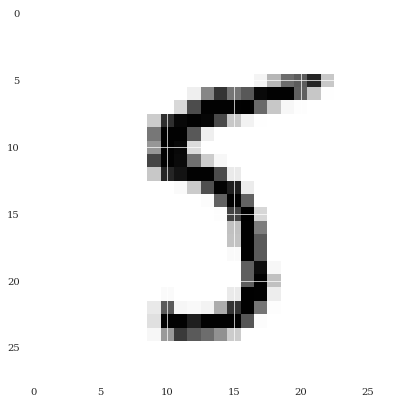

In [9]:
im=next(iter(train_loader))
fig=plt.figure()
plt.imshow(im[0][0, 0, :, :])
plt.savefig("sampleMNIST.pdf")

In [13]:
from scipy.special import logsumexp

def evaluate_nll_bpd(data_loader, model, batch = 500, R = 5):
    # Set of likelihood tests
    likelihood_test = []
    # Go through dataset
    for batch_idx, (x, _) in enumerate(data_loader):
        for j in range(x.shape[0]):
            a = []
            for r in range(0, R):
                cur_x = x[j].unsqueeze(0)
                # Repeat it as batch
                x = cur_x.expand(batch, *cur_x.size()[1:]).contiguous()
                x = x.view(batch, -1)
                x_tilde, kl_div = model(x)
                rec = reconstruction_loss(x_tilde, x, average=False)
                a_tmp = (rec + kl_div)
                a.append(- a_tmp.cpu().data.numpy())
            # calculate max
            a = np.asarray(a)
            a = np.reshape(a, (a.shape[0] * a.shape[1], 1))
            likelihood_x = logsumexp(a)
            likelihood_test.append(likelihood_x - np.log(len(a)))
    likelihood_test = np.array(likelihood_test)
    nll = - np.mean(likelihood_test)
    # Compute the bits per dim (but irrelevant for binary data)
    bpd = nll / (np.prod(nin) * np.log(2.))
    return nll, bpd

In [14]:
# Plot final loss
#plt.figure()
#plt.plot(losses_kld[:, 0].numpy());
# Evaluate log-likelihood and bits per dim
nll, _ = evaluate_nll_bpd(test_loader, model)
print('Negative Log-Likelihood : ' + str(nll))

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [1, 1, 2, 2], but got 2-dimensional input of size [500, 784] instead

We can also evaluate the latent space of our model, which should be organized (being the overall point of using a VAE instead of a common AE).

In [15]:
x = np.linspace(-3, 3, 8)
y = np.linspace(-3, 3, 8)
fig = plt.figure(figsize=(10, 8))
for i in range(8):
    for j in range(8):
        plt.subplot(8, 8, (i * 8) + j + 1)
        final_tensor = torch.zeros(2)
        final_tensor[0] = x[i]
        final_tensor[1] = y[j]
        plt.imshow(model.decode(final_tensor).detach().reshape(28, 28), cmap='gray')
        plt.axis('off')

Error in callback <function flush_figures at 0x000002772E48AD38> (for post_execute):


KeyboardInterrupt: 